In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split

from keras.layers import LSTM, Input, Dense
from keras.models import Model

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

np.random.seed(1120)

In [3]:
data = pd.read_csv('./all/train.csv')
data = np.reshape(np.array(data['wp1']),(len(data['wp1']),1))
print(data[:10])
train_data = data[0:17257]
test_data = data[17257:]

[[0.045]
 [0.085]
 [0.02 ]
 [0.06 ]
 [0.045]
 [0.035]
 [0.005]
 [0.   ]
 [0.   ]
 [0.01 ]]


In [4]:
def prepare_dataset(data, window_size):
    X, Y = np.empty((0,window_size)), np.empty((0))
    for i in range(len(data)-window_size-1):
        X = np.vstack([X,data[i:(i + window_size),0]])
        Y = np.append(Y,data[i + window_size,0])   
    X = np.reshape(X,(len(X),window_size,1))
    Y = np.reshape(Y,(len(Y),1))
    return X, Y

X_train,y_train = prepare_dataset(train_data,3)
print(X_train)
print(y_train)

[[[0.045]
  [0.085]
  [0.02 ]]

 [[0.085]
  [0.02 ]
  [0.06 ]]

 [[0.02 ]
  [0.06 ]
  [0.045]]

 ...

 [[0.09 ]
  [0.11 ]
  [0.11 ]]

 [[0.11 ]
  [0.11 ]
  [0.095]]

 [[0.11 ]
  [0.095]
  [0.14 ]]]
[[0.06 ]
 [0.045]
 [0.035]
 ...
 [0.095]
 [0.14 ]
 [0.15 ]]


In [7]:
def train_evaluate(ga_individual_solution):  
    
    # Decode the Genetic Algorithm solution to get the window size and number of bits
    window_size_bits = BitArray(ga_individual_solution[0:6])
    num_units_bits = BitArray(ga_individual_solution[6:]) 
    window_size = window_size_bits.uint
    num_of_units = num_units_bits.uint
    print('\nWindow Size: ', window_size, ', Num of Units: ', num_of_units)
    
    # Return fitness score of 100 if window_size or num_unit is zero
    if window_size == 0 or num_of_units == 0:
        return 100, 
    
    # Segment the train_data based on new window_size; 
    # Split the dataset into train set(80) and validation set(20)
    X_data,Y_data = prepare_dataset(train_data,window_size)
    X_train, X_val, y_train, y_val = split(X_data, Y_data, test_size = 0.20, random_state = 1120)
    
    # Design an LSTM model to train on training data and predict on validation data
    input_ph = Input(shape=(window_size,1))
    x = LSTM(num_of_units, input_shape=(window_size,1))(input_ph)
    predicted_values = Dense(1, activation='tanh')(x)
    model = Model(inputs=input_ph, outputs=predicted_values)
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=5, batch_size=20,shuffle=True)
    y_pred = model.predict(X_val)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('Validation RMSE: ', rmse,'\n')
    
    return rmse,

In [8]:
population_size = 4
num_generations = 4
gene_length = 10

#Implementation of Genetic Algorithm using DEAP python library.

#Since we try to minimise the loss values, we use the negation of the root mean squared loss as fitness function.
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

#initialize the variables as bernoilli random variables
toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

#Ordered cross-over used for mating
toolbox.register('mate', tools.cxOrdered)
#Shuffle mutation to reorder the chromosomes
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
#use roulette wheel selection algorithm
toolbox.register('select', tools.selRoulette)
#training function used for evaluating fitness of individual solution.
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)

/home/sunandini/.local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/sunandini/.local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



Window Size:  34 , Num of Units:  9
Epoch 1/5
13777/13777 [==============================] - 13s 934us/step - loss: 0.0391
Epoch 2/5
13777/13777 [==============================] - 11s 763us/step - loss: 0.0114
Epoch 3/5
13777/13777 [==============================] - 11s 770us/step - loss: 0.0080
Epoch 4/5
13777/13777 [==============================] - 10s 746us/step - loss: 0.0065
Epoch 5/5
13777/13777 [==============================] - 10s 749us/step - loss: 0.0059
Validation RMSE:  0.07639846236008416 


Window Size:  28 , Num of Units:  2
Epoch 1/5
13782/13782 [==============================] - 9s 650us/step - loss: 0.0234
Epoch 2/5
13782/13782 [==============================] - 9s 628us/step - loss: 0.0108
Epoch 3/5
13782/13782 [==============================] - 9s 629us/step - loss: 0.0078
Epoch 4/5
13782/13782 [==============================] - 9s 678us/step - loss: 0.0065
Epoch 5/5
13782/13782 [==============================] - 9s 688us/step - loss: 0.0060
Validation RMSE:  0.0

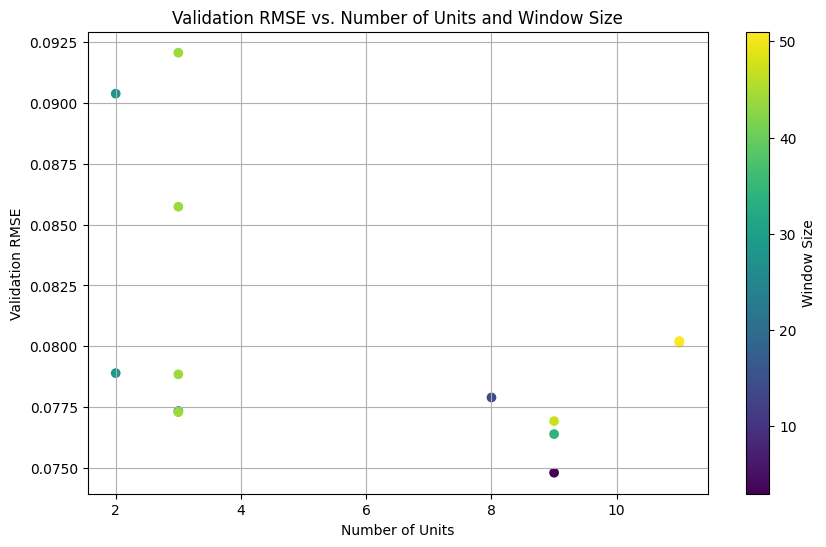

In [1]:
import matplotlib.pyplot as plt

# Data from the provided output
window_sizes = [34, 28, 14, 44, 28, 32, 3, 51, 44, 44, 44, 51, 47]
num_units = [9, 2, 8, 3, 2, 3, 9, 11, 3, 3, 3, 11, 9]
val_rmse = [0.07639846236008416, 0.0789012736107829, 0.07789992243052019, 0.09205666537789764, 0.0903745636888513, 0.07735020071476466, 0.07481095347319817, 0.08021812863991828, 0.08573251545653714, 0.07729665050321902, 0.07885058974021525, 0.08014650106123256, 0.07693006095112899]

# Create a scatter plot with different colors for each window size
plt.figure(figsize=(10, 6))
plt.scatter(num_units, val_rmse, c=window_sizes, cmap='viridis')
plt.xlabel('Number of Units')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE vs. Number of Units and Window Size')
plt.colorbar(label='Window Size')
plt.grid(True)
plt.show()

In [11]:
optimal_individuals_data = tools.selBest(population,k = 1) #select top 1 solution
optimal_window_size = None
optimal_num_units = None

for bi in optimal_individuals_data:
    window_size_bits = BitArray(bi[0:6])
    num_units_bits = BitArray(bi[6:]) 
    optimal_window_size = window_size_bits.uint
    optimal_num_units = num_units_bits.uint
    print('\n Best Window Size: ', optimal_window_size, ', Best Num of Units: ', optimal_num_units)



 Best Window Size:  47 , Best Num of Units:  9


In [12]:
#hence train the model with the optimal number of lstm units and optimal window size for prediction
X_train,y_train = prepare_dataset(train_data,optimal_window_size)
X_test, y_test = prepare_dataset(test_data,optimal_window_size)

inputs = Input(shape=(optimal_window_size,1))
x = LSTM(optimal_num_units, input_shape=(optimal_window_size,1))(inputs)
predictions = Dense(1, activation='tanh')(x)
model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train, y_train, epochs=5, batch_size=20,shuffle=True)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: ', rmse)

Epoch 1/5
17209/17209 [==============================] - 21s 1ms/step - loss: 0.0190
Epoch 2/5
17209/17209 [==============================] - 18s 1ms/step - loss: 0.0078
Epoch 3/5
17209/17209 [==============================] - 18s 1ms/step - loss: 0.0062
Epoch 4/5
17209/17209 [==============================] - 19s 1ms/step - loss: 0.0060
Epoch 5/5
17209/17209 [==============================] - 19s 1ms/step - loss: 0.0060
Test RMSE:  0.09710418381525192


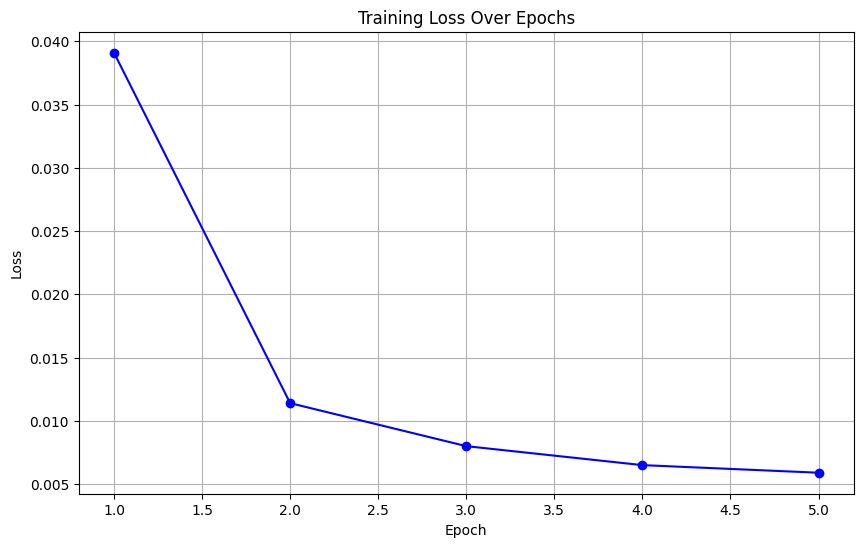

In [2]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
loss_values = [0.0391, 0.0114, 0.0080, 0.0065, 0.0059]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()